In [1]:
import numpy as np
import random
import numpy as np
import tqdm
import json
import matplotlib.pyplot as plt
import h5py
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin #for GridSearchCv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

<h2>Preprocessing</h2>

<h3>Outlier Detection</h3>

In [2]:
class OutlierDetection:
    """
    Parameters
    None

    Return
    (event_data,new_event_lengths) (packed np.arrays): outliers removed packed data

    """
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        data,event_lengths = X
        event_data = np.full_like(data, np.nan)
        new_event_lengths = np.full_like(event_lengths, np.nan)
        tot_count = 0

        for i in range(len(data)):
            event_points = data[i,:event_lengths[i]]
            condition = ((-280 <= event_points[:, 0]) & (event_points[:, 0] <= 280) &    #CHATGPT helped in this condition statement
                (-280 <= event_points[:, 1]) & (event_points[:, 1] <= 280) &
                (0 <= event_points[:, 2]) & (event_points[:, 2]  <= 1000))
            
            allowed_points = event_points[condition] #only allows points that are not outliers
            event_data[i,:len(allowed_points)] = allowed_points #only assigns the valid points to the new array
            event_data[i,-2] = data[i,-2] #need to include the labels
            event_data[i,-1] = data[i,-1] #need to inclde the orinigal index

            new_event_lengths[i] = len(allowed_points)  #original event number minus the number of outliers
            tot_count+=event_lengths[i] -new_event_lengths[i]

        print(f"Number of outlier points removed: {tot_count}") 
        return (event_data,new_event_lengths)
                        

<h3>Up/Down Scaling</h3>

In [3]:
class UpDownScaling(BaseEstimator,TransformerMixin):
    """
    Parameters
    target_size (int): which is the number of point I want to up/doen sample to 

    Return
    new_data (np.array): up/down sampled data with shape (run_events, target_size,4) 

    """
    def __init__(self,target_size,dimension=4,isotope="16O"):
        self.target_size = target_size
        self.pcloud_zeros = 0 #count if there are zero points in an event
        self.dimension = dimension 
        self.isotope = isotope

    def fit(self,X,y=None):
        return self 

    def transform(self,X,y=None): #for up/down scaling
        data,event_lengths = X #with shape (file,event_lenghts) X needs to be the only input to preserve the conventions of custom transformer
        len_run = len(data)
        # new_array_name = isotope + '_size' + str(sample_size) + '_sampled'
        new_data = np.full((len_run, self.target_size+2, self.dimension), np.nan) 

        for i in tqdm.tqdm(range(len_run)): #
            ev_len = event_lengths[i] #length of event-- i.e. number of instances
            if ev_len == 0: #if event length is 0
                self.pcloud_zeros+=1
                continue
            if ev_len > self.target_size: #upsample
                random_points = np.random.choice(ev_len, self.target_size, replace=False)  #choosing the random instances to sample
                for r in range(len(random_points)):  # #only adds random sample_size points 
                    new_data[i,r] = data[i,random_points[r]]

            else:
                new_data[i,:ev_len,:] = data[i,:ev_len,:] #downsample
                need = self.target_size - ev_len
                random_points = np.random.choice(ev_len, need, replace= True if need > ev_len else False) #only repeats points more points needed than event length 
                count = ev_len
                for r in random_points:
                    new_data[i,count] = data[i,r]
                    if np.isnan(new_data[i, count, 0]):
                        print(f"NaN found at event {i}, index {count}") #need to make sure no nans remain
                    count += 1
            new_data[i,-2] = data[i,-2] # saving the label
            new_data[i,-1] = data[i,-1] # saving the event index

        assert self.pcloud_zeros ==0, "There are events with no points"
        assert new_data.shape == (len_run, self.target_size+2, self.dimension), 'Array has incorrect shape'
        assert len(np.unique(new_data[:,-1,0]))+self.pcloud_zeros == len_run, 'Array has incorrect number of events'
        assert not np.isnan(new_data).any(), "NaNs detected in new_data" #very imporant to make sure there are no nans 
        print(f"Transformed shape of data: {new_data.shape}")
        return new_data

<h3>Tracks to Class (subtracting 1)</h3>

In [4]:
class ReclassifyingLabels(BaseEstimator,TransformerMixin):
    """
    Parameters
    None

    Return
    X_copy (np.array): labels recalucated but the same data shape remains same  (run_events, target_size,4) 

    """
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self 
    
    def transform(self, X,y=None):
        X_copy = X.copy() #don't want to change the labels from the oriiginal
        for i in range(len(X_copy)):
            if X_copy[i,-2,0] == 0:
                print("Event has 0 tracks")
                print("Event:",i," label:", X_copy[i,-2,0])
            else:
                X_copy[i,-2,0] -=1 

        return X_copy

<h3>Data Augumentation</h3>

In [5]:
class DataAugumentation(BaseEstimator,TransformerMixin):
    """
    Parameters
    target_size (int): which is the number of point of the second dimension

    Return
    augmented_data (np.array): increased shape of array by the number of augumneted events for class 3 and 4

    """
    def __init__(self,target_size):
        self.target_size = target_size
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        labels = X[:,-2,0].astype(int)
        class_dist = np.array([np.sum(labels==i) for i in range(5)]) #there are 5 labels (0-5) 
        print(f"Data shape before data augmentation: {X.shape}")
        print(f"The class distribution before augmentation: {class_dist}")

        multipliers = {0: 0, 1: 0, 2: 0, 3: 8, 4: 103}
        augmented_length = sum(class_dist[c] * m for c, m in multipliers.items()) #this will account for multiplier increase (chatgpt helped)
        augumented_data = np.full((augmented_length+len(X),X.shape[1],X.shape[2]),np.nan)
        augumented_data[:len(X)] = X #filling up the original events 
        new_start = len(X)
        current_idx = len(X)
        for i in range(len(X)):
            if labels[i] not in (3,4): #we only want to inrease class 3 and 4
                continue
            
            if labels[i] == 3:
                multiplier = multipliers[3]
            else:
                multiplier = multipliers[4]
            
            event = X[i]
            event_points = event[:-2]

            for j in range(multiplier):
                theta = np.random.uniform(0, 2 * np.pi) #rotation about the z-axis
                cos, sin= np.cos(theta), np.sin(theta) #need to get the conversion
                points_rot = event_points.copy() #don't want to change the original points 
                x, y = points_rot[:,0],points_rot[:,1] #original x and y points 
                points_rot[:,0] = cos * x - sin * y 
                points_rot[:,1] = sin * x + cos * y 

                augumented_data[current_idx] = np.concatenate([points_rot, event[-2:]], axis=0)
                current_idx+=1

        labels = augumented_data[:,-2,0].astype(int)
        class_dist = np.array([np.sum(labels==i) for i in range(5)]) #there are 5 labels (0-5) 
        print(f"The class distribution after augumentation: {class_dist}")


        return augumented_data

<h3>Scaling</h3>

In [6]:
class ScalingData(BaseEstimator,TransformerMixin):
    """
    Parameters
    None

    Return
    X (np.array): MinMaxScaler() applied data for all columns

    """
    def __init__(self,dimension=4):
        self.dimension = dimension
        self.scaler = MinMaxScaler(feature_range=(-1, 1))

    def fit(self,X,y=None):
        return self 
    
    def transform(self,X,y=None):
        n_dict = {0:"x",1:"y",2:"z",3:"charge"}
        for n in range(self.dimension):
            data = X[:, :-2, n].reshape(-1, 1) #need to flatted the 2-D array first new shape (num_events*target_size)
            X[:, :-2, n] = self.scaler.fit_transform(data).reshape(X.shape[0], X.shape[1]-2)
            print(f"Scaler min and max for feature {n_dict[n]}: {self.scaler.data_min_[0]}, {self.scaler.data_max_[0]}")

        return X

In [7]:
pipeline_1 = Pipeline([
    ("outlier",OutlierDetection()), #getting rid of the outliers
    ("sampler", UpDownScaling(target_size=800)),
]) #up/down sampler 

pipeline_2 = Pipeline([
    ("reclassify",ReclassifyingLabels()),
    ("augument", DataAugumentation(target_size=800)),
    ("scaling", ScalingData())
]) #reclassifying and scaling (w/ concatonated dataset)

run_num_list = [104,105,106,108] #from a selectin of [104,105,106,108,109,110,111,112]
sum_data = None

for run_num in run_num_list:
    data =  np.load(f"/Users/mahesh/Desktop/academics/spring 2025/applied ml/ml_final_project/processed_data/run0{run_num}_data.npy")
    event_lengths = np.load(f"/Users/mahesh/Desktop/academics/spring 2025/applied ml/ml_final_project/processed_data/run0{run_num}_evtlen.npy")
    assert data.shape == (event_lengths.size, np.max(event_lengths)+2, 4), f"Array {run_num} has incorrect shape"
    assert len(np.unique(data[:,-1,0])) == event_lengths.size, f"Array {run_num} has incorrect event_ids" 
    data_static = pipeline_1.fit_transform((data,event_lengths))
    print()
    if sum_data is None: #the first iteration only 
        sum_data = data_static
    else:
        sum_data = np.concatenate((sum_data,data_static),axis=0)




/Users/mahesh/Desktop/academics/spring 2025/applied ml/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:452: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


Number of outlier points removed: 5643


100%|██████████| 3746/3746 [00:02<00:00, 1471.22it/s]


Transformed shape of data: (3746, 802, 4)

Number of outlier points removed: 379


100%|██████████| 527/527 [00:00<00:00, 1168.41it/s]


Transformed shape of data: (527, 802, 4)

Number of outlier points removed: 1553


100%|██████████| 4079/4079 [00:02<00:00, 1405.85it/s]


Transformed shape of data: (4079, 802, 4)

Number of outlier points removed: 1356


100%|██████████| 3637/3637 [00:02<00:00, 1392.51it/s]


Transformed shape of data: (3637, 802, 4)



In [8]:
transformed_data = pipeline_2.fit_transform(sum_data)
print()
print(f"The full transformed data shape: {transformed_data.shape}")

Data shape before data augmentation: (11989, 802, 4)
The class distribution before augmentation: [3846 3846 3846  414   37]
The class distribution after augumentation: [3846 3846 3846 3726 3848]
Scaler min and max for feature x: -272.5977985164127, 272.5478453476196
Scaler min and max for feature y: -355.6107185337221, 357.1103960916983
Scaler min and max for feature z: 88.38725062018574, 999.9974153769894
Scaler min and max for feature charge: 41.0, 3847.0

The full transformed data shape: (19112, 802, 4)


<h3>Outlier omission confirmation</h3>

In [9]:
mask = np.any((transformed_data[:, :800, :3] > 1) | (transformed_data[:, :800, :3] < -1), axis=(1, 2))
indices = np.argwhere(mask)
assert len(indices) == 0, "Points remain that are not within range[-1,1]"

<h3>Splitting</h3>

In [10]:
y = transformed_data[:,-2,0] 

data_train_val, data_test = train_test_split(
    transformed_data, test_size=0.2, stratify=y, random_state=42
) #need to preserve class distribution 

y_train_val = data_train_val[:, -2, 0]  
data_train, data_val = train_test_split(
    data_train_val, test_size=0.5, stratify=y_train_val, random_state=42
) #need to preserve class distribution and ensure we train on all classes

X_train = data_train[:,:-2,:] 
y_train = data_train[:,-2,0] 

X_val = data_val[:,:-2,:] 
y_val = data_val[:,-2,0]  

X_test = data_test[:,:-2,:] 
y_test = data_test[:,-2,0] 



In [11]:
train_shape = X_train.shape
print(f"The training set shape: {train_shape}")

The training set shape: (7644, 800, 4)


<h2>Model Training</h2>

<h3>CNN</h3>

In [12]:
from tensorflow.keras import layers, models,Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.optimizers import Adam

model = Sequential() #not Functional() as I do not have multiple inputs or outputs 
model.add(layers.Input(shape=(800,4)))
###########################################Comment out this bock for ANN ####################################################################
#convolutional layer 1
model.add(Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')) #if data is noisy, may want to up the kernel size start w/3
#no dr with the paddding (input shape = output shape)
#may need to try variable braches of Conv1D (but later) -> to explore both fine and coarse structure 
model.add(layers.MaxPooling1D(pool_size=2)) #reduce size by half

#convolutional layer 2
model.add(Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')) 
model.add(layers.MaxPooling1D(pool_size=2)) 

#convolutional layer 3
model.add(Conv1D(filters=128, kernel_size=3, activation="relu", padding='same')) 
model.add(layers.MaxPooling1D(pool_size=2)) 

#convolutional layer 4
model.add(Conv1D(filters=256, kernel_size=3, activation="relu", padding='same')) 
model.add(layers.MaxPooling1D(pool_size=2)) 

#convolutional layer 5
model.add(Conv1D(filters=512, kernel_size=3, activation="relu", padding='same')) 
model.add(layers.MaxPooling1D(pool_size=2)) 
###########################################################################################################################################


#ANN comprable to the CNN here 
#flattening layer
model.add(layers.Flatten()) #need to flatted (the input to the fully connected layers)

#fully connected layer 1
model.add(layers.Dense(512, activation="relu")) #number of neurons first input

#fully connected layer 2
model.add(layers.Dense(256, activation="relu")) #number of neurons first input

#fully connected layer 3
model.add(layers.Dense(128, activation="relu")) #number of neurons first input

#softmax layers
model.add(layers.Dense(5,activation="softmax")) #last layer with the 5 classes

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 800, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 200, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 100, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 50, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 25, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,242,597 (27.63 MB)

 Trainable params: 7,242,597 (27.63 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

def cnn_model(batch,lr):
    optimizer = Adam(learning_rate=lr) #lowering the learning after 
    model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"]) #labels can be single integrers with sparse_categorical_crossentropy
    early_stop = EarlyStopping(
    monitor="val_loss",      #looking at validation loss 
    patience=5,     #when there is no change within 5 epochs           
    restore_best_weights=True #retains that weights from the best model version
    )
    history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, #set this to a high number because we have early stop
    batch_size=batch,  #may be a batch size dependence
    callbacks=[early_stop], #will stop training with the restrictions set by eary_stop
    verbose=1
    )
    return history

In [14]:
batch_sizes = [16, 32, 64] #
histories = []
models_arr=[]
for batch in batch_sizes:
    histories.append(cnn_model(batch, lr=1e-5))
    models_arr.append(model)
    



Epoch 1/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 57s 116ms/step - accuracy: 0.2379 - loss: 1.5825 - val_accuracy: 0.4072 - val_loss: 1.3084
Epoch 2/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 59s 123ms/step - accuracy: 0.4635 - loss: 1.1938 - val_accuracy: 0.5589 - val_loss: 0.9993
Epoch 3/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 52s 108ms/step - accuracy: 0.5786 - loss: 0.9217 - val_accuracy: 0.5906 - val_loss: 0.9059
Epoch 4/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 49s 103ms/step - accuracy: 0.6379 - loss: 0.7933 - val_accuracy: 0.5958 - val_loss: 0.8776
Epoch 5/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 59s 124ms/step - accuracy: 0.6789 - loss: 0.6894 - val_accuracy: 0.6161 - val_loss: 0.8215
Epoch 6/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 53s 110ms/step - accuracy: 0.7420 - loss: 0.5784 - val_accuracy: 0.6377 - val_loss: 0.7971
Epoch 7/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 51s 106ms/step - accuracy: 0.8039 - loss: 0.4631 - val_accuracy: 0.6348 - val_loss: 0.9252
Epoch 8/50
478/478 ━━━━━━━━━━━━━━━━━━━━ 59s 124ms/step - accuracy: 0.8579 - loss: 0

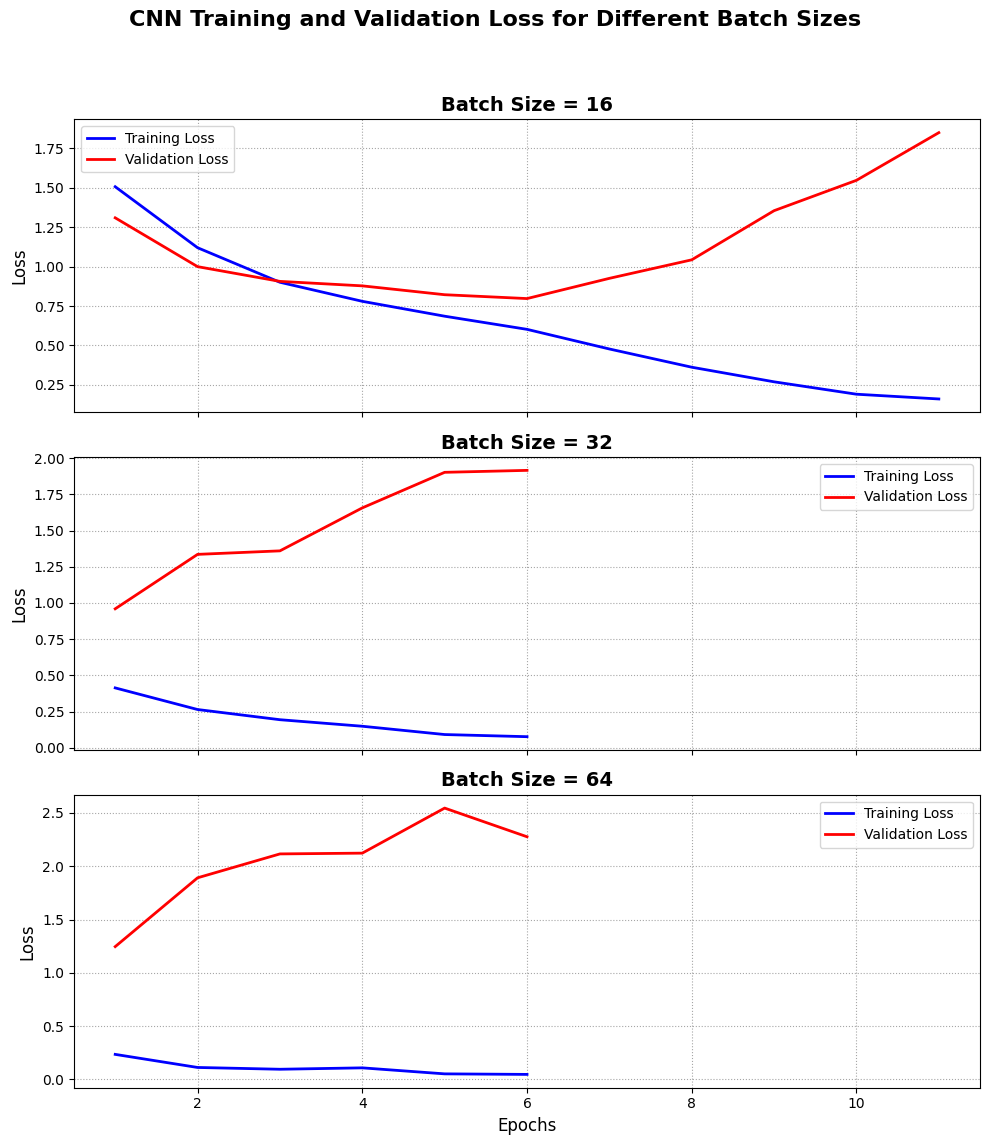

In [15]:
#VISUALIZTION from CHATGPT

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i, history in enumerate(histories):
    batch = batch_sizes[i]
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    axs[i].plot(epochs, hist["loss"], label="Training Loss", color="b", linewidth=2)
    axs[i].plot(epochs, hist["val_loss"], label="Validation Loss", color="r", linewidth=2)

    axs[i].set_title(f"Batch Size = {batch}", fontsize=14, fontweight="bold")
    axs[i].set_ylabel("Loss", fontsize=12)
    axs[i].legend()
    axs[i].grid(True, linestyle=":", color="gray", alpha=0.7)

axs[-1].set_xlabel("Epochs", fontsize=12)
plt.suptitle("CNN Training and Validation Loss for Different Batch Sizes", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


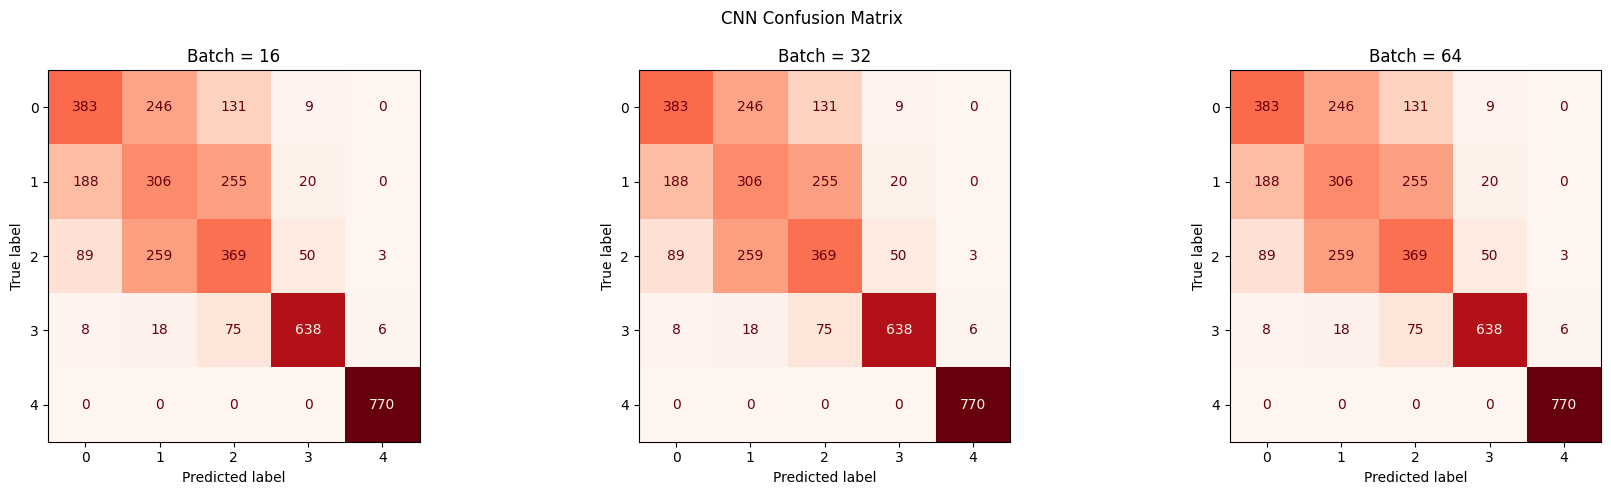

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#VISUALIZATION FROM CHAT GPT

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, model in enumerate(models_arr):
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_test, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Reds, ax=axs[i], colorbar=False)
    axs[i].set_title(f"Batch = {batch_sizes[i]}")
plt.suptitle("CNN Confusion Matrix")
plt.tight_layout()
plt.show()

In [20]:
print(predicted_classes)

[3 3 3 ... 4 1 2]


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_classes,zero_division=0.0)) #need to include zero division because the model is not predicting for certain classes 

              precision    recall  f1-score   support

         0.0       0.57      0.50      0.53       769
         1.0       0.37      0.40      0.38       769
         2.0       0.44      0.48      0.46       770
         3.0       0.89      0.86      0.87       745
         4.0       0.99      1.00      0.99       770

    accuracy                           0.65      3823
   macro avg       0.65      0.65      0.65      3823
weighted avg       0.65      0.65      0.65      3823



In [22]:
print(np.unique(predicted_classes)) #need to make sure all classes are predicted

[0 1 2 3 4]
